For this capstone project I will be working on identifying online harassment using NLP.  Why focus on harassment?  Well, for starters, it's a problem that affects a quarter of the population in the U.S.  Additionally, according to a [2021 Pew research poll]( (https://www.pewresearch.org/internet/2021/01/13/the-state-of-online-harassment/)), 79% of respondants "say social media companies are doing an only fair or poor job at addressing online harassment or bullying on their platforms."  Our goal is to construct a virtual moderator, or vMOD, a NLP model that is capable of predicting if a comment is harassment, or not, and automatically blocks users who are sending hateful comments.


"Fully 33% of women under 35 say they have been sexually harassed online", For those who identify as LBGTQA, "51% have been targeted for more severe forms of online abuse."

"Among adults who have been harassed online, roughly half of women (47%) say they think they have encountered harassment online because of their gender, whereas 18% of men who have been harassed online say the same. Similarly, about half or more Black (54%) or Hispanic online harassment targets (47%) say they were harassed due to their race or ethnicity, compared with 17% of White targets."


[Plos article](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0221152)



## Key points to remember:
The Natural Language Tool Kit (NLTK) is one of the most popular Python libraries for NLP

Regular Expressions are an important part of NLP, which can be used for pattern matching and filtering

**Regular Expressions** can become confusing, so make sure to use our provided *cheat sheet* the first few times you work with regex

It is strongly recommended you take some time to use regex tester websites to ensure you understand how changing your regex pattern affects your results when working towards a correct answer!

**Feature Engineering** is essential when working with text data, and to understand the dynamics of your text:
* Common feature engineering techniques are removing stop words, stemming, lemmatization, and n-grams
* When diving deeper into grammar and linguistics, context-free grammars and part-of-speech tagging is important
* In this context, parse trees can help computers when dealing with ambiguous words

How you clean and preprocess your data will have a major effect on the conclusions you'll be able to draw in your NLP classification problems

# Data Understanding

Our data comes from a [Kaggle competetion](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data), Identifying Toxic Comments, a dataset comprising of...points
measures of central tendency, spread, give broad narrative of data itself.  


Then talk about automating process using [Kaggle API key](https://www.kaggle.com/docs/api).

## Import Data
In this section we'll take a preliminary look at our data to get a feel for what we're working with. Let's begin with our import statements and then by taking a look at the contents of our train data directory.

In [ ]:
import sys, re, os, csv, codecs, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from google.colab import drive

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

import shutil

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt



In [ ]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

In [ ]:
# Get current directory
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'drive', 'sample_data']


In [9]:
# Set path to xrays.  Hint- right click on the file you want to copy file path
drive_path = '/content/drive/MyDrive/Colab_Notebooks/jigsaw-toxic-comment-classification-challenge.zip'


In [10]:
# Navigate to xrays
!cp '{drive_path}' .

In [ ]:
# Get current directory/confirm correct path
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'drive', 'jigsaw-toxic-comment-classification-challenge.zip', 'sample_data']


In [11]:
# Unzip imagecomments
!unzip '/content/jigsaw-toxic-comment-classification-challenge.zip'

Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [12]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')
test_labels= pd.read_csv('test_labels.csv.zip')


## Inspect Data

In [13]:
train.shape

(159571, 8)

In [14]:
train.isnull().values.any()


False

In [ ]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [49]:
len = train.comment_text.str.len()
print("Shortest comment:", len.min(), "words")
print("Longest comment:", len.max(), "words")
print("Average comment:", len.mean().round(0), "words")




Shortest comment: 6 words
Longest comment: 5000 words
Average comment: 394.0 words


In [39]:
# Sum totals for each of our toxic category columns
x= train.iloc[:, 2:].sum()

x

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [40]:
labels= train.drop(['id', 'comment_text'], axis=1)

In [44]:
labels[labels==True].count().sum()

35098

<Axes: >

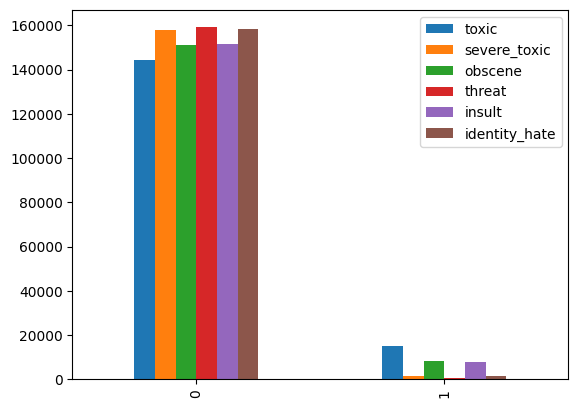

In [46]:
df1 = labels.apply(pd.value_counts)
df1.plot.bar()


### Class Imbalance
We can see there is a clear class imbalance in our data- far more records have no toxic languge (0) than do (1).  We'll need to take this into account when building our model.


# Data Preprocessing
Before we can begin cleaning and preprocessing our text data, we need to make some decisions about things such as:

* Do we remove stop words or not?
* Do we stem or lemmatize our text data, or leave the words as is?
* Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
*Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
* Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
* What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

Another common decision point when working with text data is exactly what features to include in the dataset. As we saw in a previous lab, NLTK makes it quite easy to do things like generate part-of-speech tags for words, or create word or character-level n-grams. In general, there's no great answer for exactly which features will improve the performance of your model, and which won't. This means that your best bet is to experiment, and treat the entire project as an iterative process! When working with text data, don't be afraid to try modeling on alternative forms of the text data, such as bigrams or n-grams. Similarly, we encourage you to explore how adding in additional features such as POS tags or mutual information scores affect the overall model performance.



Various python libraries like nltk, spaCy, and TextBlob can be used

The various text preprocessing steps are:

1. Tokenization: Using NLTK

2. Lower casing: for sentance in files: sentence.lower


3. Stop words removal:

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
  
sentence = "Machine Learning is cool!
  
stop_words = set(stopwords.words('english'))
word_tokens = word_tokenize(sentence)
  
filtered_sentence = [w for w in word_tokens if not w in stop_words]
print(filtered_sentence)

4. Stemming

import nltk

from nltk.stem import PorterStemmer

ps = PorterStemmer()

sentence = "Machine Learning is cool"

for word in sentence.split():
  print(ps.stem(word))

5. Lemmatization: Better than stemming but uses more computational power.  Reduces word to root

import nltk

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()


In [ ]:
def doc_preparer(doc, stop_words=sw):
    '''

    :param doc: a document from the satire corpus
    :return: a document string with words which have been
            lemmatized,
            parsed for stopwords,
            made lowercase,
            and stripped of punctuation and numbers.
    '''

    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer()
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
from nltk.corpus import stopwords
import string

# Get all the stop words in the English language
stopwords_list = stopwords.words('english')

# It is generally a good idea to also remove punctuation

# Now we have a list that includes all english stopwords, as well as all punctuation
stopwords_list += list(string.punctuation)

In [ ]:
from nltk import word_tokenize

tokens = word_tokenize(some_text_data)

# It is usually a good idea to lowercase all tokens during this step, as well
stopped_tokens = [w.lower() for w in tokens if w not in stopwords_list]


## Bayes's Theorem Again
Let's revisit Bayes's Theorem. Remember, the idea is to calculate the probability of the correct application of a class label (c) given some data (x). To do so, we calculate the likelihood (the distribution of our data within a given class) and the prior probabiliity of each class (the probability of seeing the class in the population). We are going generally to ignore the denominator of the right side of the equation because it will be constant.

# Making things BERT friendly
BERT, which stands for Bidirectional Encoder Representations from Transformers

First let's make the data compliant with BERT:

Column 0: An ID for the row. (Required both for train and test data.)
Column 1: The class label for the row. (Required only for train data.)
Column 2: A column of the same letter for all rows — this is a throw-away column that we need to include because BERT expects it. (Required only for train data.)
Column 3: The text examples we want to classify. (Required both for train and test data.)

We need to split the files into the format expected by BERT: BERT comes with data loading classes that expects two files called train and dev for training. In addition, BERT’s data loading classes can also use a test file but it expects the test file to be unlabelled.


Once the data is in the correct format, we need to save the files as .tsv (BERT doesn't take .csv as input.)



In [ ]:
# A dependency of the preprocessing for BERT inputs
pip install -U "tensorflow-text==2.13.*"

In [ ]:
pip install "tf-models-official==2.13.*"

In [ ]:
# Creating training dataframe according to BERT by adding the required columns
df_bert = pd.DataFrame({
    'id':range(len(train_df)),
    'label':train_df[0],
    'alpha':['a']*train_df.shape[0],
    'text': train_df[1].replace(r'\n', ' ', regex=True)
})

In [ ]:
# Saving dataframes to .tsv format as required by BERT
df_bert_train.to_csv('data/train.tsv', sep='\t', index=False, header=False)
df_bert_dev.to_csv('data/dev.tsv', sep='\t', index=False, header=False)
df_bert_test.to_csv('data/test.tsv', sep='\t', index=False, header=False)

3. Training Model using Pre-trained BERT model
Some checkpoints before proceeding further:

All the .tsv files should be in a folder called “data” in the “BERT directory”.
We should have created a folder “bert_output” where the fine tuned model will be saved.
The pre-trained BERT model should have been saved in the “BERT directory”.
The paths in the command are relative path, “./”
Now, navigate to the directory you cloned BERT into and type the following command:

